# Access watershed routing information

Ming Han and colleagues have recently published a [pan-Canadian river routing information geospatial database](https://zenodo.org/record/3667677#.YEag8-2YVH4). It describes river channels, lakes and reservoirs, watershed slopes and river slopes, enbankments, mean elevation, etc. This database is hosted on the PAVICS geoserver and a few utilities have been created to access it. This information can then be used to create Raven configuration files for sub-basins routing in distributed model configurations. 

This notebook demonstrates how to build a table of watershed properties from version 1 of this geospatial database. Version 2 should become available in April or May and this will be updated, so consider this notebook as a draft. 

In [1]:
import geopandas as gpd
from ravenpy.utilities import geoserver
from owslib import wfs

## Get routing information for a given location 

Here we're fetching watershed information for the subbasin including [Amadjuak Lake](https://en.wikipedia.org/wiki/Amadjuak_Lake), located on Baffin Island's Great Plain of the Koukdjuak (Nunavut), using `geoserver.get_hydro_routing_location_wfs()`.

,id,area,SubId,DowSubId,Rivlen,RivSlope,BasinSlope,BkfWidth,BkfDepth,IsLake,...,Laketype,IsObs,MeanElev,FloodP_n,Q_Mean,Ch_n,INSIDE_X,INSIDE_Y,STATION_NU,geometry
0,routing_1kmLakes_07.16393,9.110308e+09,29881,30001,132876,0.000069,0.012235,46.6959,1.14224,1,...,1,-9999.99,144.388,0.048342,49.4539,0.008963,-71.318408,64.787276,,"MULTIPOLYGON (((-72.04580 65.22920, -72.04580 ..."


<AxesSubplot:>

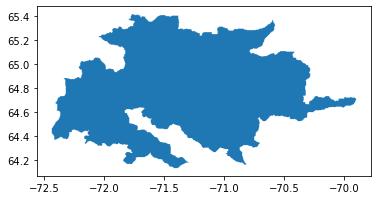

In [2]:
amadjuak = (-71.225, 65.05)

feature = geoserver.get_hydro_routing_location_wfs(
    coordinates=amadjuak * 2, lakes="1km", level=7
)

feat = gpd.read_file(feature.decode())  # decode converts bytes to string
display(feat)
feat.plot(aspect="equal")

## Fetching routing information for upstream watersheds

With the subbasin ID (`SubId`) for the feature, we can now find all upstream watersheds using `geoserver.hydro_routing_upstream_ids()`. 

This function requires information about up-down relationships between watersheds. We can get this info using `geoserver.get_hydro_routing_attributes_wfs()`. This function returns a URL to a JSON-encoded subset, and GeoPandas uses some magic to load it into a GeoDataFrame. Getting this info takes a while... 

In [3]:
subbasin_id = feat['SubId'][0]
gdf = geoserver.hydro_routing_upstream(subbasin_id, lakes="1km", level=7)
gdf

Number of features: 33


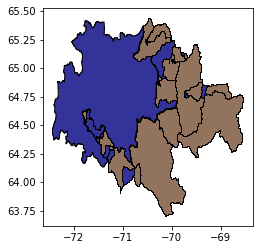

In [6]:
# Plotting all features upstream of the subbasin of interest, including Amadjuak Lake. 
# Lakes are in blue and land in brown. 
# Note that the contours show basins that include lakes, not the lakes themselves.

gdf.plot(column="IsLake", cmap="terrain_r", edgecolor="black", vmin=-14000)
print(f"Number of features: {len(gdf)}")

## Routing configuration

The routing information stored on Geoserver is from version 1 of the routing database. The RavenPy code was however designed with V2 as a target, which is not yet publicly available. The following code uses a test data sample from V2 to illustrate how the routing information can be used to configure Raven. V2 should become available in Spring 2021. 

In [9]:
import geopandas as gpd
from ravenpy.models import GR4JCN, get_average_annual_runoff
from ravenpy.models.importers import RoutingProductShapefileImporter
from ravenpy.models.commands import SBGroupPropertyMultiplierCommand
from ravenpy.utilities.testdata import get_local_testdata
import datetime as dt

In [7]:
path = get_local_testdata("raven-routing-sample/finalcat_hru_info.zip")
config = RoutingProductShapefileImporter(path).extract(model=GR4JCN)
total_area = sum(hru.area for hru in config['hrus']) * 1E6

`config` is a dictionary of Raven configuration objects. 

In [8]:
print(config.keys())

dict_keys(['subbasins', 'land_subbasins', 'lake_subbasins', 'reservoirs', 'channel_profiles', 'hrus'])


In [10]:
ts = get_local_testdata("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily_2d.nc")
model = GR4JCN()
model(ts=ts, 
      params=model.params(0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
      start_date=dt.datetime(2000, 1, 1),
      end_date=dt.datetime(2002, 1, 1),
      routing="ROUTE_DIFFUSIVE_WAVE",
      avg_annual_runoff=get_average_annual_runoff(ts, total_area),
      land_subbasin_property_multiplier = SBGroupPropertyMultiplierCommand("Land", "MANNINGS_N", 1.0),
      lake_subbasin_property_multiplier = SBGroupPropertyMultiplierCommand("Lakes", "RESERVOIR_CREST_WIDTH", 1.0),
      **config)

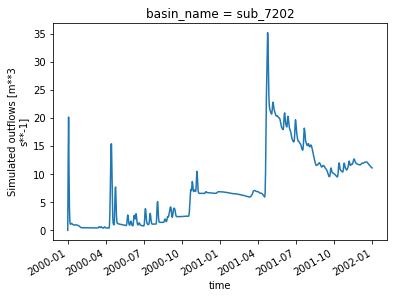

In [13]:
model.q_sim.plot()